In [3]:
# !pip install wandb

In [1]:
# 1. Imports and setup
import os
import gzip
import pickle
import requests
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score

# Weights & Biases for experiment tracking
import wandb

In [2]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# 2. Download & load MNIST
data_dir = Path("data/mnist")
data_dir.mkdir(parents=True, exist_ok=True)
url = "https://github.com/pytorch/tutorials/raw/main/_static/mnist.pkl.gz"
fpath = data_dir / "mnist.pkl.gz"
if not fpath.exists():
    print("Downloading MNIST dataset...")
    fpath.write_bytes(requests.get(url).content)
with gzip.open(fpath, "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
# Convert to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_valid = torch.tensor(x_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.long)
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Valid: {x_valid.shape}, {y_valid.shape}")


Train: torch.Size([50000, 784]), torch.Size([50000])
Valid: torch.Size([10000, 784]), torch.Size([10000])


In [5]:
# 3. Data augmentation & DataLoader definitions
normalize = transforms.Normalize((0.1307,), (0.3081,))
train_transforms = transforms.Compose([
    transforms.ToTensor(), normalize,
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
])
valid_transforms = transforms.Compose([transforms.ToTensor(), normalize])

class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images, self.labels, self.transform = images, labels, transform
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        img = self.images[idx].view(28,28).numpy()
        img = self.transform(img) if self.transform else torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        return img, self.labels[idx]

batch_size = 64
train_dl = DataLoader(MNISTDataset(x_train, y_train, transform=train_transforms), batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(MNISTDataset(x_valid, y_valid, transform=valid_transforms), batch_size=batch_size*2)
print(f"Batches: train={len(train_dl)}, valid={len(valid_dl)}")


Batches: train=782, valid=79


In [6]:
# 4. Model definition (wider+deeper) with BatchNorm and Dropout
class MnistCNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,32,3,2,1), nn.BatchNorm2d(32), nn.ReLU(), nn.Dropout2d(0.1),  #28→14
            nn.Conv2d(32,32,3,2,1), nn.BatchNorm2d(32), nn.ReLU(), nn.Dropout2d(0.1), #14→7
            nn.Conv2d(32,16,3,2,1), nn.BatchNorm2d(16), nn.ReLU(),                    #7→4
            nn.Conv2d(16,10,3,1,1), nn.BatchNorm2d(10), nn.ReLU(),                    #4→4
            nn.AdaptiveAvgPool2d(1), nn.Flatten()                                      #4×4→1×1→(batch,10)
        )
    def forward(self,x): return self.net(x)
model = MnistCNN2().to(device)
print(model)


MnistCNN2(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): AdaptiveAvgPool2d(output_size=1)
    (15): Flatten(start_dim=1, end_dim=-1)
  )
)


In [9]:
# 5. Training & validation functions
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = loss_fn(model(xb), yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

def valid_epoch(model, loader, loss_fn):
    model.eval()
    running_loss = 0.0
    all_preds, all_targs = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            running_loss += loss_fn(preds, yb).item() * xb.size(0)
            all_preds.append(preds.argmax(1).cpu())
            all_targs.append(yb.cpu())
    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(torch.cat(all_targs), torch.cat(all_preds))
    return avg_loss, acc

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /teamspace/studios/this_studio/.netrc
wandb: Currently logged in as: peprodev (peprodev-gt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1: train_loss=1.1801, valid_loss=0.3427, valid_acc=0.9309
Epoch 2: train_loss=0.4717, valid_loss=0.1925, valid_acc=0.9567
Epoch 3: train_loss=0.3520, valid_loss=0.1361, valid_acc=0.9665
Epoch 4: train_loss=0.2955, valid_loss=0.1142, valid_acc=0.9719
Epoch 5: train_loss=0.2661, valid_loss=0.1038, valid_acc=0.9736
Epoch 6: train_loss=0.2451, valid_loss=0.0975, valid_acc=0.9754
Epoch 7: train_loss=0.2292, valid_loss=0.0889, valid_acc=0.9776
Epoch 8: train_loss=0.2174, valid_loss=0.0871, valid_acc=0.9768
Epoch 9: train_loss=0.2097, valid_loss=0.0837, valid_acc=0.9781
Epoch 10: train_loss=0.2036, valid_loss=0.0745, valid_acc=0.9799
Epoch 11: train_loss=0.1962, valid_loss=0.0741, valid_acc=0.9804
Epoch 12: train_loss=0.1902, valid_loss=0.0717, valid_acc=0.9814
Epoch 13: train_loss=0.1849, valid_loss=0.0726, valid_acc=0.9782
Epoch 14: train_loss=0.1791, valid_loss=0.0698, valid_acc=0.9809
Epoch 15: train_loss=0.1733, valid_loss=0.0645, valid_acc=0.9821


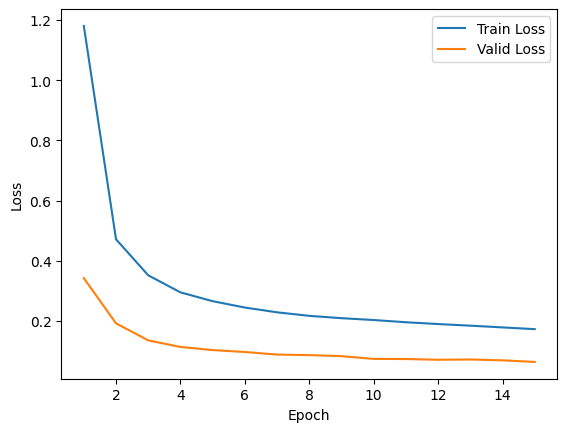

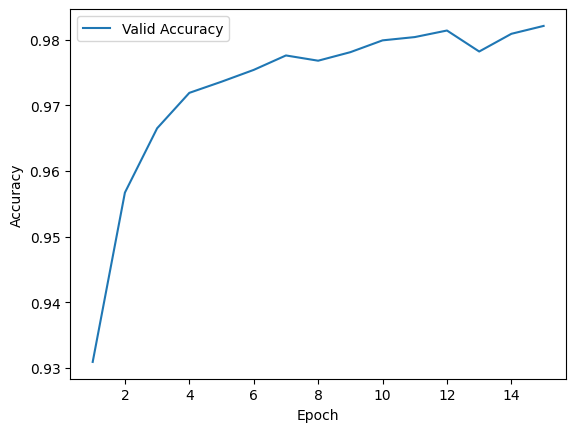

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,▁▁▁▁▂▂▃▃▄▄▅▅▆▇█
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
valid_acc,▁▅▆▇▇▇▇▇▇███▇██
valid_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch,15
lr,0.004
train_loss,0.1733
valid_acc,0.9821
valid_loss,0.0645


In [10]:
# 6. Experiment: W&B run + training with OneCycleLR
wandb.init(project="mnist_experiment", config={
    "epochs": 15,
    "lr": 0.1,
    "weight_decay": 1e-4,
    "batch_size": batch_size,
})
config = wandb.config
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=0.9, weight_decay=config.weight_decay)
steps_per_epoch = len(train_dl)
total_steps = config.epochs * steps_per_epoch
scheduler = OneCycleLR(optimizer, max_lr=config.lr, total_steps=total_steps)
loss_fn = F.cross_entropy

train_losses, valid_losses, valid_accs = [], [], []
for epoch in range(1, config.epochs+1):
    tl = train_epoch(model, train_dl, optimizer, loss_fn)
    vl, va = valid_epoch(model, valid_dl, loss_fn)
    scheduler.step()
    # Log metrics
    wandb.log({"train_loss": tl, "valid_loss": vl, "valid_acc": va, "epoch": epoch, "lr": scheduler.get_last_lr()[0]})
    print(f"Epoch {epoch}: train_loss={tl:.4f}, valid_loss={vl:.4f}, valid_acc={va:.4f}")
    train_losses.append(tl)
    valid_losses.append(vl)
    valid_accs.append(va)
# Save final model
torch.save(model.state_dict(), f"mnist_cnn2_final.pth")
wandb.save(f"mnist_cnn2_final.pth")

# 7. Plot results
plt.figure()
plt.plot(range(1, config.epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, config.epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

plt.figure()
plt.plot(range(1, config.epochs+1), valid_accs, label='Valid Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

# 8. Finish W&B run
wandb.finish()

Classification Report:
              precision    recall  f1-score   support

           0     0.9879    0.9859    0.9869       991
           1     0.9887    0.9878    0.9882      1064
           2     0.9788    0.9808    0.9798       990
           3     0.9874    0.9893    0.9884      1030
           4     0.9886    0.9705    0.9795       983
           5     0.9867    0.9716    0.9791       915
           6     0.9717    0.9938    0.9826       967
           7     0.9809    0.9881    0.9845      1090
           8     0.9840    0.9772    0.9806      1009
           9     0.9659    0.9740    0.9699       961

    accuracy                         0.9821     10000
   macro avg     0.9821    0.9819    0.9819     10000
weighted avg     0.9822    0.9821    0.9821     10000



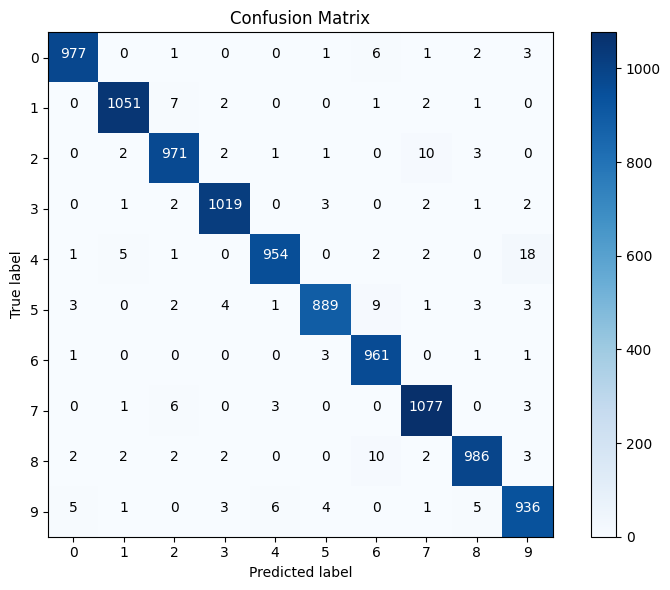

Macro ROC-AUC: 0.9997


In [ ]:

import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# 8. Evaluate on official test split
# Load best saved model
final_model_path = "mnist_cnn2_final.pth"  
best_model = MnistCNN2().to(device)
best_model.load_state_dict(torch.load(final_model_path, map_location=device))
best_model.eval()

# Prepare test DataLoader (no augmentation)
test_dl = DataLoader(MNISTDataset(x_valid, y_valid, transform=valid_transforms), batch_size=batch_size*2)

all_preds, all_targets, all_probs = [], [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        logits = best_model(xb)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(yb.numpy())
all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Classification report
print("Classification Report:")
print(classification_report(all_targets, all_preds, digits=4))

# Confusion matrix
target_names = [str(i) for i in range(10)]
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(range(10), target_names)
plt.yticks(range(10), target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
# Annotate
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
plt.tight_layout()
plt.show()

# ROC-AUC (one-vs-rest)
y_true_bin = label_binarize(all_targets, classes=list(range(10)))
macro_roc_auc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='macro')
print(f"Macro ROC-AUC: {macro_roc_auc:.4f}")

# Plot ROC curves for a subset of classes
plt.figure()
for i in range(10):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC={roc_auc_score(y_true_bin[:, i], all_probs[:, i]):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (one-vs-rest)')
plt.legend(loc='lower right')
plt.show()

# 9. Finish W&B run
wandb.finish()

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

import wandb

# Start a new W&B run for evaluation
run = wandb.init(
    project="mnist_experiment",
    job_type="evaluation",
    name="test_split_evaluation",
    reinit=True
)

# 8. Evaluate on official test split
# Load best saved model
final_model_path = "mnist_cnn2_final.pth"  
best_model = MnistCNN2().to(device)
best_model.load_state_dict(torch.load(final_model_path, map_location=device))
best_model.eval()

# Prepare test DataLoader (no augmentation)
test_dl = DataLoader(MNISTDataset(x_valid, y_valid, transform=valid_transforms),
                     batch_size=batch_size*2)

all_preds, all_targets, all_probs = [], [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        logits = best_model(xb)
        probs = F.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(yb.numpy())

all_probs   = np.vstack(all_probs)
all_preds   = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Classification report
report_dict = classification_report(all_targets, all_preds, output_dict=True, digits=4)
report_txt  = classification_report(all_targets, all_preds, digits=4)
print("Classification Report:\n", report_txt)

# Log per-class precision, recall, f1
metrics = {"test_accuracy": report_dict["accuracy"]}
for cls, scores in report_dict.items():
    if cls.isdigit():
        metrics[f"precision/{cls}"] = scores["precision"]
        metrics[f"recall/{cls}"]    = scores["recall"]
        metrics[f"f1/{cls}"]        = scores["f1-score"]
wandb.log(metrics)

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
fig_cm, ax_cm = plt.subplots(figsize=(8,6))
im = ax_cm.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax_cm.set(title="Confusion Matrix", xlabel="Predicted", ylabel="True",
          xticks=np.arange(10), yticks=np.arange(10),
          xticklabels=range(10), yticklabels=range(10))
plt.colorbar(im, ax=ax_cm)
thresh = cm.max() / 2.
for i in range(10):
    for j in range(10):
        ax_cm.text(j, i, cm[i, j], ha="center",
                   color="white" if cm[i, j] > thresh else "black")
fig_cm.tight_layout()
wandb.log({"confusion_matrix": wandb.Image(fig_cm)})
plt.close(fig_cm)

# ROC-AUC (one-vs-rest)
y_true_bin = label_binarize(all_targets, classes=list(range(10)))
macro_roc = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='macro')
print(f"Macro ROC-AUC: {macro_roc:.4f}")
wandb.log({"roc_auc_macro": macro_roc})

# ROC curves
fig_roc, ax_roc = plt.subplots()
for i in range(10):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    auc_i = roc_auc_score(y_true_bin[:, i], all_probs[:, i])
    ax_roc.plot(fpr, tpr, label=f"{i} (AUC={auc_i:.2f})")
ax_roc.plot([0,1], [0,1], "k--")
ax_roc.set(title="ROC Curves (one-vs-rest)", xlabel="FPR", ylabel="TPR")
ax_roc.legend(loc="lower right")
wandb.log({"roc_curves": wandb.Image(fig_roc)})
plt.close(fig_roc)

# 9. Finish W&B run
wandb.finish()


wandb: Currently logged in as: peprodev (peprodev-gt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Classification Report:
               precision    recall  f1-score   support

           0     0.9879    0.9859    0.9869       991
           1     0.9887    0.9878    0.9882      1064
           2     0.9788    0.9808    0.9798       990
           3     0.9874    0.9893    0.9884      1030
           4     0.9886    0.9705    0.9795       983
           5     0.9867    0.9716    0.9791       915
           6     0.9717    0.9938    0.9826       967
           7     0.9809    0.9881    0.9845      1090
           8     0.9840    0.9772    0.9806      1009
           9     0.9659    0.9740    0.9699       961

    accuracy                         0.9821     10000
   macro avg     0.9821    0.9819    0.9819     10000
weighted avg     0.9822    0.9821    0.9821     10000

Macro ROC-AUC: 0.9997


f1/0,▁
f1/1,▁
f1/2,▁
f1/3,▁
f1/4,▁
f1/5,▁
f1/6,▁
f1/7,▁
f1/8,▁
f1/9,▁
precision/0,▁
